## Desafio Chest-Xray
### Top-5 maneiras de crashar o Google Colab.

Primeiro passo obtenção dos dados.

In [0]:
#!wget https://data.mendeley.com/datasets/rscbjbr9sj/2/files/41d542e7-7f91-47f6-9ff2-dd8e5a5a7861/ChestXRay2017.zip

In [0]:
#!unzip ChestXRay2017.zip

In [0]:
#!ls

In [4]:
!pip install tqdm
!pip install imblearn

    100% |████████████████████████████████| 51kB 1.4MB/s 
    100% |████████████████████████████████| 153kB 4.8MB/s 


In [5]:
import tqdm
import os
import h5py
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import keras
import skimage.transform

from tqdm import tqdm

from sklearn.utils import class_weight
from keras.models import Model

from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from keras import Sequential
from keras.layers import  Dropout, Flatten, Dense, Lambda,ZeroPadding2D,Convolution2D,MaxPooling2D,AlphaDropout, Conv2D, BatchNormalization
from datetime import datetime

Using TensorFlow backend.


In [0]:
import cv2

Código para gerar os dados de treino e teste a partir dos arquivos e salvar em um arquivo h5 para não ter que repetir o procedimento de downloadar/dezipar/e formatar os dados toda vez.

#### Primeiro crash: resize das imagens para as dimensões 224x224 

In [0]:
#def get_data(folder):
#    X = []
#    y = []
#    for folderName in os.listdir(folder):
#        if not folderName.startswith('.'):
#            if folderName in ['NORMAL']:
#                label = 0
#            elif folderName in ['PNEUMONIA']:
#                label = 1
#            else:
#                label = 2
#            for image_filename in tqdm(os.listdir(folder + folderName)):
#                img_file = cv2.imread(folder + folderName + '/' + image_filename)
#                if img_file is not None:
#                    img_file = skimage.transform.resize(img_file, (150, 150, 3))  #  <-------------- (150 x 150) pra funcionar no colab
#                    img_arr = np.asarray(img_file)
#                    X.append(img_arr)
#                    y.append(label)
#    X = np.asarray(X)
#    y = np.asarray(y)
#    return X,y
#X_train, y_train = get_data("chest_xray/train/")
#X_test, y_test= get_data("chest_xray/test/")

#hf = h5py.File('dataset_chestxray.h5', 'w')

#hf.create_dataset('X_train', data=X_train)
#hf.create_dataset('y_train', data=y_train)
#hf.create_dataset('X_test', data=X_test)
#hf.create_dataset('y_test', data=y_test)
#hf.close()

código para inserir e obter os dados do google drive, caso a conexão com o kernel do colab caia

In [0]:
from google.colab import files

In [0]:
!pip install -U -q PyDrive

In [0]:


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

In [0]:
file_id = '18mf4qqeP895Zj3FMsVy7hzqZwT9W19Qn'

!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters

#file_list = drive.ListFile(
#    {'q': "'18mf4qqeP895Zj3FMsVy7hzqZwT9W19Qn' in parents"}).GetList()

#for f in file_list:
  # 3. Create & download by id.
#  print('title: %s, id: %s' % (f['title'], f['id']))
  
fname = os.path.join(local_download_path,'dataset_chestxray.h5')
  #print('downloading to {}'.format(fname))
f_ = drive.CreateFile({'id':'18mf4qqeP895Zj3FMsVy7hzqZwT9W19Qn' })
f_.GetContentFile(fname)



In [0]:
with h5py.File(fname,'r') as hf:
    X_train = hf['X_train'][:]
    y_train = hf['y_train'][:]
    X_test = hf['X_test'][:]
    y_test = hf['y_test'][:]

In [14]:
X_train.shape

(5232, 150, 150, 3)

In [15]:
type(X_train)

numpy.ndarray

Olhada nos dados de treinamento...
Aparentemente estão ordenados primeiro os sem pneumonia e depois os com pneumonia... (lembrar de colocar o shuffle=True na função fit

In [16]:
y_train

array([0, 0, 0, ..., 1, 1, 1])

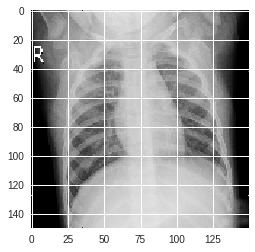

In [17]:
plt.imshow(X_train[2])

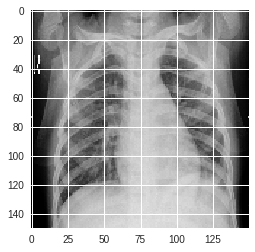

In [18]:
plt.imshow(X_train[-2]);

In [0]:
from collections import Counter

In [20]:
Counter(y_train)

Counter({0: 1349, 1: 3883})

Verificar que os dados estão não balanceados...

#### Segundo Crash: balancear com Oversample SMOTE 

In [0]:
y_train_ta = keras.utils.to_categorical(y_train, 2)
y_test_te = keras.utils.to_categorical(y_test, 2)

In [0]:
from imblearn.under_sampling import RandomUnderSampler

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
#X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
#X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = y_train
#Y_test = y_test

#ros = RandomOverSampler(ratio='auto')
ros = RandomUnderSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
#X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])

Y_trainRosHot = keras.utils.to_categorical(Y_trainRos, num_classes = 2)

#Y_testRosHot = to_categorical(Y_testRos, num_classes = 2)

# Make Data 2D again
for i in range(len(X_trainRos)):
    height, width, channels = 150,150,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
    


Aqui eu fiquei com dúvida se deveríamos de fato mexer nos dados de teste. O autor que postou o dataset mexeu nos dados de teste. Eu acho que cria Bias no modelo então não alterei o balanceamento dos dados de teste

Como o Anderson comentou que as redes como a VGG16, Inception , Resnet foram treinadas com muitas imagens, não achei que o tamanho do dataset disponibilizado ( com a resolução possível no colab) seria suficiente pra treinar uma rede do zero... <Br>
Então já optei pelo Transfer Learning de cara

eu testei a VGG16, VGG19 e Inception, o melhor resultado foi com a Vgg16 mesmo como esperado

In [0]:
from keras.applications.vgg16 import VGG16
#from keras.applications.vgg19 import VGG19

In [0]:
vgg16_pretreinada = VGG16(include_top=False, input_shape=X_train[0].shape)



In [0]:
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
 

Eu percebi que a VGG16 do keras ( só do keras? ) não tinha regularização, então utilizei as chamadas de API do keras para separar algumas layers e testar Dropout entre elas e BatchNormalization

#### Terceiro crash:  BatchNormalization()  no Colab 

O melhor resultado mesmo foi sem nenhuma regularização dentro da VGG16 . Faz sentido, pois os pesos dentro da rede já estão setados para não ter regularização.

Também testei o Data augmentation do Keras, mas o desempenho também caiu. Na verdade eu já tinha testado em outros exercícios e tinha a noção que sem estudar o método de augmentation e entender que operações devem ser feitas nos dados para aumentar o dataset, o desempenho tende a piorar mesmo.

Me restou calibrar o top-level com difeerentes parâmetros mesmo. <br>
Optimizer, número de neurônios, activation, earlystop/checkpoint

### Quarto crash:  Resource Exhaustion Número de neurônios nas últimas camadas

In [0]:
def pretrainedNetwork(xtrain,ytrain,xtest,ytest,pretrainedmodel,numclasses,numepochs,optimizer):
    
    
    base_model = pretrainedmodel # Topless
    # Add top layer
    
    

    dropout6 = Dropout(0.65)
    dropout7 = Dropout(0.65)
    
    #dropout2 = Dropout(0.85)
    #dropout8 = Dropout(.5)
    dense1 = Dense(512, kernel_initializer='he_normal', activation='relu')
    dense2 = Dense(512, kernel_initializer='he_normal', activation='relu')
    
    
    x = base_model.output
    x = Flatten()(x)
    x = dense1(x)
    x = dropout6(x)
   
    x = dense2(x)
    x= dropout7(x)
    #x= dropout8(x)
    
    
    predictions = Dense(numclasses, activation='sigmoid')(x)
    
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    
    # Train top layer
    for layer in base_model.layers:
      layer.trainable = False
    
    model.compile(loss='binary_crossentropy',  optimizer=optimizer,  metrics=['accuracy'])
    
    #callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=10, verbose=1)]
    
        
    filepath="new_weights.best.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# check 5 epochs
    early_stop = EarlyStopping(monitor='val_acc', patience=15, mode='max') 
    callbacks_list = [checkpoint, early_stop]
  
       
    model.summary()
    
      
    model.fit(xtrain,ytrain, epochs=numepochs, validation_data=(xtest,ytest),  batch_size=30, shuffle=True,verbose=1,callbacks = callbacks_list)
      
    #model.fit_generator( train_generator,  steps_per_epoch=len(X_train)//batch_size, epochs=numepochs,validation_data=(xtest,ytest), shuffle=True,verbose=1,callbacks = callbacks_list)
    
    
    model.load_weights(filepath, by_name=False)
      
      
    scores = model.evaluate(xtrain, ytrain, verbose=0)
    print("Training %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
      
    scores = model.evaluate(xtest, ytest, verbose=0)
    print("Test %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
      
      
  
    
    return model

In [0]:
#adam=keras.optimizers.Adam(lr=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-08,decay=0.0)

In [119]:


model=pretrainedNetwork(X_trainRosReshaped, Y_trainRosHot, X_test, y_test_te,vgg16_pretreinada,2,50,'adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
from sklearn.metrics import f1_score

Última ideia: Ensemble vou tentar gerar mais de uma rede e tirar a média dos resultados

#### Quinto crash: Memmory crash.  <br>

Para conseguir um ensemble razoavelmente interessante teria que subir mais umas 4 ou 6 redes. Na segunda rede, já ocorria Resource exhaustion.  

In [0]:
pred=[]
for i in model.predict(X_test):
  if i[0]>=.5:
    pred.append(0)
  else:
    pred.append(1)
    

In [0]:
#y_test

In [130]:
sum(np.array(np.array(pred)==y_test,dtype=int))/len(y_test)

0.9038461538461539

In [131]:
f1_score(y_test, pred)

0.9249999999999999

In [0]:
from sklearn.metrics import classification_report

In [133]:
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

          0       0.91      0.83      0.87       234
          1       0.90      0.95      0.92       390

avg / total       0.90      0.90      0.90       624



Nada muito excelente, mas um monte de lições aprendidas. <Br><br>
Primeiro: Não dependa do Colab ou plataformas "gratuitas". Nada supera o próprio equipamento ou o serviço pago...<br>
Segundo: estudar os dados é fundamental para construir o modelo. Esse era um caso típico de augmentation e tratamento dos dados<br>    
Terceiro: Os Ensembles são fundamentais nestes casos, em um subset menor dos dados eu consegui uma melhoria significativa +-2%, mas não dava pra utilizar como resultado na competição.